In [1]:
from os import path

import sys
sys.path.append(path.join("..", "notebooks"))
sys.path.append(path.join("..", "notebooks", "utils.py"))
import utils

import openTSNE

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import string
import gzip
import pickle
from sklearn import decomposition

import matplotlib.pyplot as plt
%matplotlib inline

# Pancreas

In [3]:
adata = anndata.read_h5ad(path.join("..", "data", "baron_2016h.h5ad"))
new = anndata.read_h5ad(path.join("..", "data", "xin_2016.h5ad"))

In [4]:
adata.obs["source"] = "Baron 2016"
adata

AnnData object with n_obs × n_vars = 8569 × 20125 
    obs: 'batch_id', 'labels', 'source'
    uns: 'name', 'organism', 'tissue', 'year'

In [5]:
new.obs["source"] = "Xin 2016"
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
new = new[cell_mask].copy()
new

AnnData object with n_obs × n_vars = 1492 × 39851 
    obs: 'batch_id', 'disease', 'age', 'sex', 'labels', 'source'
    uns: 'name', 'organism', 'tissue', 'year'

In [6]:
full = adata.concatenate(new)
sc.pp.filter_genes(full, min_counts=1)
full

AnnData object with n_obs × n_vars = 10061 × 18136 
    obs: 'age', 'batch', 'batch_id', 'disease', 'labels', 'sex', 'source'
    var: 'n_counts'

In [7]:
%%time
adata_norm = full.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

full.obsm["pca"] = decomposition.PCA(n_components=50).fit_transform(adata_norm.X)

CPU times: user 12.5 s, sys: 1.5 s, total: 14 s
Wall time: 4.51 s


In [8]:
%%time
affinities = openTSNE.affinity.Multiscale(
    full.obsm["pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
)
init = openTSNE.initialization.pca(full.obsm["pca"], random_state=0)
embedding = openTSNE.TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)
embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)

CPU times: user 15min 56s, sys: 16.3 s, total: 16min 12s
Wall time: 4min 30s


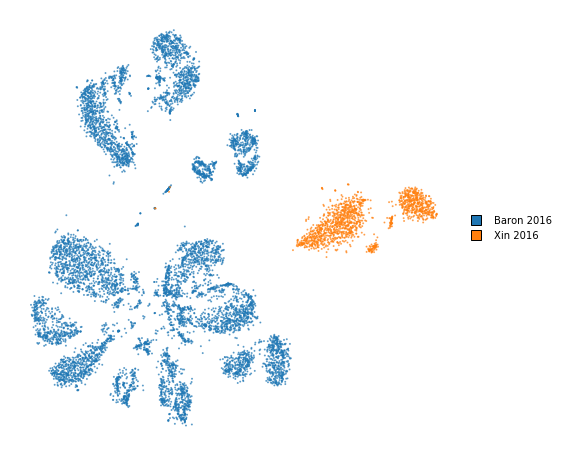

In [9]:
utils.plot(embedding, full.obs["source"])

In [10]:
with gzip.open("batch_effect_pancreas.pkl.gz", "wb") as f:
    pickle.dump(dict(embedding=embedding, source=full.obs["source"], labels=full.obs["labels"]), f)

# Brain

In [10]:
adata = anndata.read_h5ad(path.join("..", "data", "hrvatin_2018.h5ad"))
new = anndata.read_h5ad(path.join("..", "data", "chen_2017.h5ad"))

In [11]:
adata.obs["source"] = "Hrvatin 2018"
adata

AnnData object with n_obs × n_vars = 48266 × 25186 
    obs: 'labels', 'batch_id', 'paper_cell_type', 'paper_cell_subtype', 'labels_org', 'source'
    uns: 'name', 'organism', 'tissue', 'year'

In [12]:
new.obs["source"] = "Chen 2017"
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
new = new[cell_mask].copy()
new

AnnData object with n_obs × n_vars = 9687 × 23284 
    obs: 'labels', 'paper_celltype', 'batch_id', 'labels_org', 'source'
    uns: 'name', 'organism', 'tissue', 'year'

In [13]:
full = adata.concatenate(new)
sc.pp.filter_genes(full, min_counts=1)
full

AnnData object with n_obs × n_vars = 57953 × 17312 
    obs: 'batch', 'batch_id', 'labels', 'labels_org', 'paper_cell_subtype', 'paper_cell_type', 'paper_celltype', 'source'
    var: 'n_counts'

In [14]:
%%time
adata_norm = full.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

full.obsm["pca"] = decomposition.PCA(n_components=50).fit_transform(adata_norm.X)

CPU times: user 2min 54s, sys: 19.5 s, total: 3min 13s
Wall time: 19.6 s


In [15]:
%%time
affinities = openTSNE.affinity.Multiscale(
    full.obsm["pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
)
init = openTSNE.initialization.pca(full.obsm["pca"], random_state=0)
embedding = openTSNE.TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)
embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)

CPU times: user 2h 43min, sys: 2min 53s, total: 2h 45min 54s
Wall time: 9min 6s


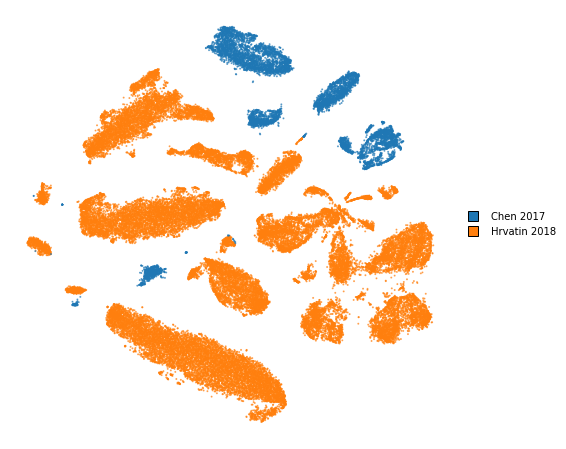

In [16]:
utils.plot(embedding, full.obs["source"])

In [17]:
with gzip.open("batch_effect_brain.pkl.gz", "wb") as f:
    pickle.dump(dict(embedding=embedding, source=full.obs["source"], labels=full.obs["labels"]), f)

# Retina

In [18]:
adata = anndata.read_h5ad(path.join("..", "data", "macosko_2015.h5ad"))
new = anndata.read_h5ad(path.join("..", "data", "shekhar_2016.h5ad"))

In [19]:
adata.obs["source"] = "Macosko 2015"
adata

AnnData object with n_obs × n_vars = 44808 × 24658 
    obs: 'batch_id', 'cluster_id', 'labels', 'source'
    var: 'genes_1000', 'genes_3000'
    uns: 'name', 'organism', 'tissue', 'year'

In [20]:
new.obs["source"] = "Shekhar 2016"
cell_mask = new.obs["labels"].isin(adata.obs["labels"])
new = new[cell_mask].copy()
new

AnnData object with n_obs × n_vars = 26830 × 24903 
    obs: 'batch_id', 'cluster_id', 'labels', 'subclusters', 'source'
    var: 'genes_1000', 'genes_3000'
    uns: 'name', 'organism', 'tissue', 'year'

In [21]:
full = adata.concatenate(new)
sc.pp.filter_genes(full, min_counts=1)
full

AnnData object with n_obs × n_vars = 71638 × 20736 
    obs: 'batch', 'batch_id', 'cluster_id', 'labels', 'source', 'subclusters'
    var: 'genes_1000-0', 'genes_3000-0', 'genes_1000-1', 'genes_3000-1', 'n_counts'

In [22]:
%%time
adata_norm = full.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

full.obsm["pca"] = decomposition.PCA(n_components=50).fit_transform(adata_norm.X)

CPU times: user 3min 45s, sys: 25.6 s, total: 4min 11s
Wall time: 27.3 s


In [23]:
%%time
affinities = openTSNE.affinity.Multiscale(
    full.obsm["pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
)
init = openTSNE.initialization.pca(full.obsm["pca"], random_state=0)
embedding = openTSNE.TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)
embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)

CPU times: user 2h 55min 56s, sys: 2min 53s, total: 2h 58min 50s
Wall time: 11min 1s


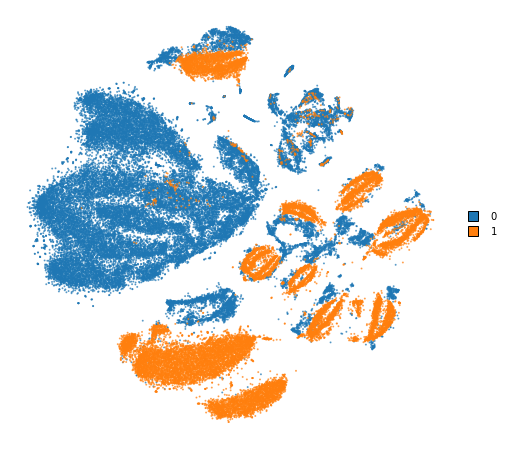

In [24]:
utils.plot(embedding, full.obs["batch"])

In [25]:
with gzip.open("batch_effect_retina.pkl.gz", "wb") as f:
    pickle.dump(dict(embedding=embedding, source=full.obs["source"], labels=full.obs["labels"]), f)